In [20]:

import numpy as np
import pandas as pd
import csv
from datetime import datetime as dt
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

#read dattaset into data
data = pd.read_csv('Art Blocks.csv', header=0)


# convert time to ordinal
# TODO:enable to delete time by using regular expression

date = [str(t1).replace(' 00:00:00','') for t1 in data['DateTime']]
# date = [str(t1).replace('\s*\d\d:\d\d:\d\d','') for t1 in data['DateTime']]
# print(date)
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in date]
print(pd.Timestamp.toordinal(dt.strptime('2017-10-01', '%Y-%m-%d')) )
print(pd.Timestamp.toordinal(dt.strptime('2022-02-01', '%Y-%m-%d')) )

# create list of observation data
#priceには'Sales USD'の列の値を用いる
#TODO:logで良いか確認
price = np.log(data['price_weekly_BTC'].values)

# create observations array (expected format for LPPLS observations)
#[time,price]の配列を作る
observations = np.array([time, price])



736603
738187


('__init__', <bound method LPPLS.__init__ of <lppls_original.LPPLS object at 0x000001D32F3A23B0>>)
('_func_compute_nested_fits', <bound method LPPLS._func_compute_nested_fits of <lppls_original.LPPLS object at 0x000001D32F3A23B0>>)
('_get_tc_bounds', <bound method LPPLS._get_tc_bounds of <lppls_original.LPPLS object at 0x000001D32F3A23B0>>)
('_is_D_in_range', <bound method LPPLS._is_D_in_range of <lppls_original.LPPLS object at 0x000001D32F3A23B0>>)
('_is_O_in_range', <bound method LPPLS._is_O_in_range of <lppls_original.LPPLS object at 0x000001D32F3A23B0>>)
('compute_indicators', <bound method LPPLS.compute_indicators of <lppls_original.LPPLS object at 0x000001D32F3A23B0>>)
('compute_nested_fits', <bound method LPPLS.compute_nested_fits of <lppls_original.LPPLS object at 0x000001D32F3A23B0>>)
('estimate_params', <bound method LPPLS.estimate_params of <lppls_original.LPPLS object at 0x000001D32F3A23B0>>)
('fit', <bound method LPPLS.fit of <lppls_original.LPPLS object at 0x000001D32F3A2

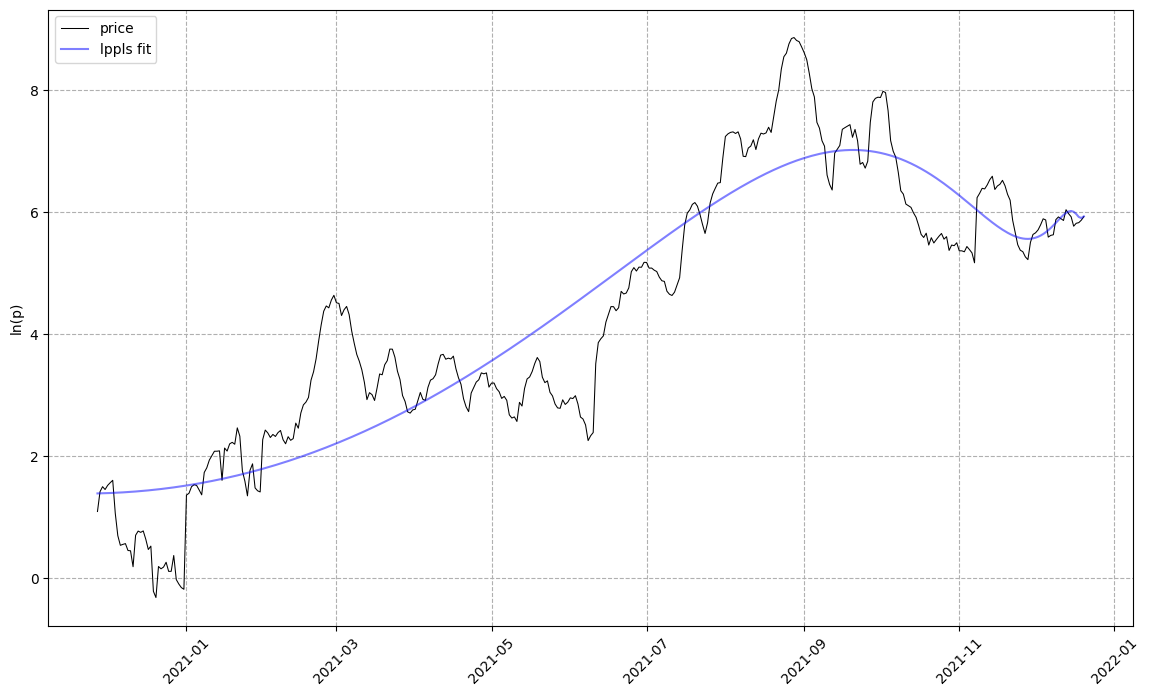

In [21]:
import lppls_original
import inspect
# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 250

# instantiate a new LPPLS model
# インスタンスを作成
lppls_model = lppls_original.LPPLS(observations=observations)
for x in inspect.getmembers(lppls_model, inspect.ismethod):
    print(x)

# fit the model to the data and get back the params
# インスタンスのフィッティングメソッドを実行し、戻り値としてパラメータの値を得る
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

# visualize the fit
lppls_model.plot_fit()


N: 389
自由度調整済み決定係数 R2: 0.8302173056418422
F値: 1898.274135074758
RSS: 319.3994398230861
SSR: 1566.6865513527932
SST: 1886.0859911758735
a: 5.92362483434506
b: -0.0020047475194155968
c1: -0.024871090728977602
c2: -0.0014581875369223572
t_a: 3.8835588185330985e-12
t_b: -0.8595915069449954
t_c1: -15.386400818890746
t_c2: -1.3158041265749278
p_a: 0.9999999999969034
p_b: 0.39054640965669174
p_c1: 0.0
p_c2: 0.18901870501919804
AIC: 1035.2530987185578


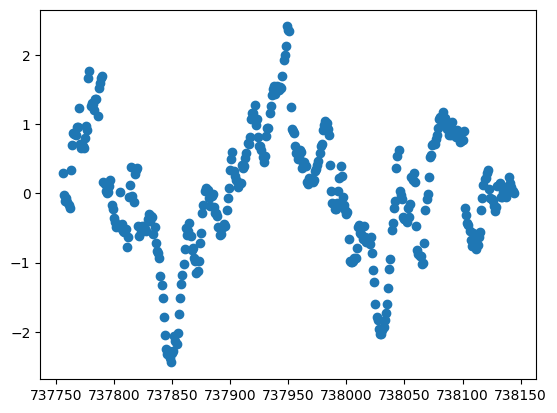

In [22]:
N = len(observations[0])

k = 1
y_hat = [lppls_model.lppls(t, tc, m, w, a, b, c1, c2) for t in observations[0, :]]
#残差：推定された回帰式から得られた値と観測データの値との差
E = np.subtract(y_hat, observations[1, :])
#squared residual
SE = np.power(E, 2)
#残差平方和　Residual Sum of Squares
SSE = np.sum(SE)
#誤差分散?
MSE = SSE / (N - k - 1)

#観測データの平均値
y_mean = np.mean(observations[1, :])
#回帰分散
regression = np.subtract(y_hat,y_mean)
SR = np.power(regression, 2)
SSR = np.sum(SR)
MSR = SSR / k

#全変動：観測データの分散
toal = np.subtract(y_mean, observations[1, :])
ST = np.power(toal, 2)
SST = np.sum(ST)
MST = SST / (N-1)

R2 = 1 - (MSE / MST)
F = MSR / MSE


def f(t, tc, m, w, a, b, c1, c2):
    return  np.power(tc - t, m)

def g(t, tc, m, w, a, b, c1, c2):
    return  np.power(tc - t, m) * np.cos(w * np.log(tc - t))
    
def h(t, tc, m, w, a, b, c1, c2):
    return  np.power(tc - t, m) * np.sin(w * np.log(tc - t))

Xc = [a] * N
Xf = [f(t, tc, m, w, a, b, c1, c2) for t in observations[0, :] ]
Xg = [g(t, tc, m, w, a, b, c1, c2) for t in observations[0, :] ]
Xh = [h(t, tc, m, w, a, b, c1, c2) for t in observations[0, :] ]

X = np.c_[Xc, Xf, Xg, Xh] 
X_error = (X - X.mean(axis=0))
s = np.dot(X_error.T, X_error)
s = np.linalg.inv(s)

std_error = np.sqrt(np.diagonal(MSE * s))

t_a = a / std_error[0]
t_b = b / std_error[1]
t_c1 = c1 / std_error[2]
t_c2 = c2 / std_error[3]

p_a = 2 * (1-stats.t.cdf(np.abs(t_a),N-k-1))
p_b = 2 * (1-stats.t.cdf(np.abs(t_b),N-k-1))
p_c1 = 2 * (1-stats.t.cdf(np.abs(t_c1),N-k-1))
p_c2 = 2 * (1-stats.t.cdf(np.abs(t_c2),N-k-1))

#AICを計算
AIC = N * np.log(2 * np.pi ) + N * np.log(MSE) + N + 2 * (k + 2)

print('N: ' + str(N))

print("自由度調整済み決定係数 R2: " + str(R2))
print("F値: " + str(F))

print("RSS: " + str(SSE))
print("SSR: " + str(SSR))
print("SST: " + str(SST))

print('a: ' + str(a))
print('b: ' + str(b))
print('c1: ' + str(c1))
print('c2: ' + str(c2))
print('t_a: ' + str(t_a))
print('t_b: ' + str(t_b))
print('t_c1: ' + str(t_c1))
print('t_c2: ' + str(t_c2))
print('p_a: ' +str(p_a))
print('p_b: ' +str(p_b))
print('p_c1: ' +str(p_c1))
print('p_c2: ' +str(p_c2))



print("AIC: " + str(AIC))

plt.scatter(observations[0],E)
plt.show()

In [23]:
# compute the confidence indicator
res = lppls_model.mp_compute_nested_fits(
    workers=8,#TODO:何?
    window_size=120, 
    smallest_window_size=30, 
    outer_increment=1, 
    inner_increment=5, 
    max_searches=25,
    # filter_conditions_config={} # not implemented in 0.6.x
)

#print(res)



# should give a plot like the following...

100%|██████████| 270/270 [01:04<00:00,  4.20it/s]


In [24]:

lppls_model.plot_confidence_indicators_one(res)

NameError: name 'dt' is not defined